<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment1/IDL_Assignment_1_Govind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.6.0'

In [35]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print('Training images shape: {}'.format(train_images.shape))
print('Test images shape: {}'.format(test_images.shape))

Training images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)


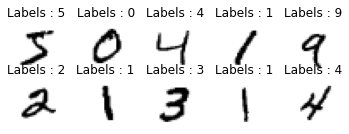

In [36]:
for i in range(10):
  plt.subplot(4, 5, i + 1)
  plt.imshow(train_images[i], cmap='gray_r')
  plt.title('Labels : {}'.format(train_labels[i]))
  plt.axis('off')

In [37]:
class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            batch = (self.train_data[self.current_pos:self.size],
                     self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]

In [38]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

###784(Input)-512(Hidden layer)-10(Output)

In [39]:
train_steps = 1000
learning_rate = 0.1

#Input layer
W_0 = tf.Variable(np.random.normal(0, 0.1, size=(784,512)).astype(np.float32))
b_0 = tf.Variable(np.random.normal(0, 0.1, size=512).astype(np.float32))

#Hidden layer
W_1 = tf.Variable(np.random.normal(0, 0.1, size=(512,10)).astype(np.float32))
b_1 = tf.Variable(np.random.normal(0, 0.1, size=10).astype(np.float32))


In [40]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:

        z0 = tf.nn.relu(tf.matmul(img_batch, W_0) + b_0)
        z1 = tf.nn.relu(tf.matmul(z0, W_1) + b_1)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=z1, labels=lbl_batch))

    grads = tape.gradient(xent, [W_0,b_0,W_1, b_1])
    W_0.assign_sub(learning_rate * grads[0])
    b_0.assign_sub(learning_rate * grads[1])
    W_1.assign_sub(learning_rate * grads[2])
    b_1.assign_sub(learning_rate * grads[3])
    
    if not step % 100:
        preds = tf.argmax(h_1, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 3.018893241882324 Accuracy: 0.125
Loss: 0.9667315483093262 Accuracy: 0.078125
Loss: 0.8321389555931091 Accuracy: 0.09375
Loss: 0.7626230716705322 Accuracy: 0.0703125
Loss: 0.7663869857788086 Accuracy: 0.1015625
Starting new epoch...
Loss: 0.8950964212417603 Accuracy: 0.1015625
Loss: 0.5091084837913513 Accuracy: 0.1171875
Loss: 0.4750341475009918 Accuracy: 0.09375
Loss: 0.44763344526290894 Accuracy: 0.0625
Loss: 0.18829093873500824 Accuracy: 0.09375
Starting new epoch...


In [41]:
test_preds = tf.argmax(tf.matmul(data.test_data, W_0) + b_0, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.0002, shape=(), dtype=float32)
